### Predicting movie user rating
This notebook contains the code for the second project I did during the Metis data science bootcamp. The question that I am trying to answer is "Can we determine the factors that influence audience reception for a movie?" The movie data has been scraped from imdb and the-numbers.com and contains US releases between 1973 and 2016 (included). I divided the notebook into the following sections:  
1. Data collection and cleaning
2. Modelling & results

In [240]:
# Get all python libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
import scipy.stats as stats
import re

%matplotlib inline

### 1. Data collection and cleaning  

The scraped data was stored in 3 csv files:
1. movie_list.csv  
2. movie_details.csv  
3. numbers_data.csv  

Let's read these files and merge them to create a single movie dataframe.

In [251]:
# Read CSV files and store in dataframe
# Scraping mvoie data from 1973 to 2016
df_movie_list = pd.read_csv('movie_list.csv')
df_movie_details = pd.read_csv('movie_details.csv')
df_movie_numbers = pd.read_csv('numbers_data.csv')
df_movie1 = pd.merge(df_movie_list, df_movie_details, on='title')
df_movie2 = pd.merge(df_movie1, df_movie_numbers, on='title')

In [254]:
df_movie2.head(3)

,director,user_rating,runtime,star1,star2,star3,star4,title,year,ratingnum,mpaa_rating,genre,meta_score,Budget
0,Quentin Tarantino,8.9,154 mins.,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,Pulp Fiction,1994,"1,379,004",R,"Crime, Drama",94,"$8,000,000"
1,Quentin Tarantino,8.9,154 mins.,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,Pulp Fiction,1994,"1,379,004",R,"Crime, Drama",94,"$8,000,000"
2,Marc Webb,6.7,142 mins.,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti,The Amazing Spider-Man 2,2014,"333,329",PG-13,"Action, Adventure, Sci-Fi",53,"$200,000,000"


In [253]:
#Remove space in columns
df_movie2.columns = [column.strip() for column in df_movie2.columns]
# Remove columns that are not needed
col_list1 = ['link', 'description', 'urating', 'rank', 'gross', 'budget', 'DomesticGross', 'WorldwideGross']
df_movie2.drop(col_list1, axis=1, inplace=True)

In [255]:
# Get rid of the duplicate entry by using movie and director combination
# As can be seen from above, pulp fiction has 2 entries
df_movie2.drop_duplicates(subset=["director", "title"], inplace=True)
df_movie2.head(3)

,director,user_rating,runtime,star1,star2,star3,star4,title,year,ratingnum,mpaa_rating,genre,meta_score,Budget
0,Quentin Tarantino,8.9,154 mins.,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,Pulp Fiction,1994,"1,379,004",R,"Crime, Drama",94,"$8,000,000"
2,Marc Webb,6.7,142 mins.,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti,The Amazing Spider-Man 2,2014,"333,329",PG-13,"Action, Adventure, Sci-Fi",53,"$200,000,000"
3,Frank Darabont,9.3,142 mins.,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,The Shawshank Redemption,1994,"1,761,024",R,"Crime, Drama",80,"$25,000,000"


In [256]:
# Clean text in columns
df_movie2['star1'] = df_movie2['star1'].apply(lambda text: re.sub('[^a-zA-Z. " "] ' '', '', text))
df_movie2['star2'] = df_movie2['star2'].apply(lambda text: re.sub('[^a-zA-Z. " "] ' '', '', text))
df_movie2['star3'] = df_movie2['star3'].apply(lambda text: re.sub('[^a-zA-Z. " "] ' '', '', text))
df_movie2['star4'] = df_movie2['star4'].apply(lambda text: re.sub('[^a-zA-Z. " "] ' '', '', text))
df_movie2['director'] = df_movie2['director'].apply(lambda text: re.sub('[^a-zA-Z. " "] ' '', '', text))
df_movie2['title'] = df_movie2['title'].apply(lambda text: re.sub('[^a-zA-Z]', ' ', text))
df_movie2['runtime'] = df_movie2['runtime'].apply(lambda text: re.sub('[^0-9]', ' ', text))
df_movie2['ratingnum'] = df_movie2['ratingnum'].apply(lambda text: re.sub('[^0-9]', '', text))
df_movie2['year'] = df_movie2['year'].apply(lambda text: re.sub('[^0-9]', '', text))
df_movie2['Budget'] = df_movie2['Budget'].apply(lambda text: re.sub('[^0-9]', '', text))

In [257]:
# Combine individual star into list and create a new column stars1
df_movie2['stars'] = df_movie2[['star1', 'star2', 'star3', 'star4']].apply(lambda x: ','.join(x), axis=1)
df_movie2['stars'] = df_movie2['stars'].astype('str')
df_movie2['stars1'] = df_movie2['stars'].apply(lambda names: names.split(','))

In [258]:
# Drop individual star columns
df_movie2.drop(['star1', 'star2', 'star3', 'star4', 'stars'], axis=1, inplace=True)

In [259]:
df_movie2.columns

Index([u'director', u'user_rating', u'runtime', u'title', u'year',
       u'ratingnum', u'mpaa_rating', u'genre', u'meta_score', u'Budget',
       u'stars1'],
      dtype='object')

In [260]:
# Convert stars into categorical varaible
# top_actor_list contains the top 20 actors between 1970 and present
top_actor_list = ['Harrison Ford', 'Samuel L. Jackson', 'Morgan Freeman', 'Tom Hanks', 'Robert Downey Jr.', 
                  'Eddie Murphy', 'Tom Cruise', 'Johnny Depp', 'Michael Caine', 'Gary Oldman', 
                  'Robin Williams', 'Bruce Willis', 'Robert De Niro', 'Matt Damon', 'Liam Neeson', 
                  'Scarlett Johansson', 'Cameron Diaz', 'Helena Bonham Carter', 'Will Smith', 'Julia Roberts']
for actor in top_actor_list:
    df_movie2[actor] = 0

In [261]:
for index, row in df_movie2.iterrows():
    for actor in row['stars1']:
        actor = actor.strip()
        if actor in top_actor_list:        
            df_movie2.set_value(index, actor, 1)   

In [262]:
# # Convert director into categorical varaible
# top_directpr_list contains the top 10 directors between 1970 and present
top_director_list = ['Steven Spielberg', 'James Cameron', 'Woody Allen', 'Martin Scorsese', 'Clint Eastwood', 'David Fincher', 'Ridley Scott', 'Robert Zemeckis', 'Ang Lee', 'Alejandro G. Iñárritu']
for director in top_director_list:
    df_movie2[director] = 0

In [263]:
for index, row in df_movie2.iterrows():
    if row['director'] in top_director_list:
         df_movie2.set_value(index, row['director'], 1)   

In [265]:
# Convert genre into categorical variables
df_movie2['genre'] = df_movie2['genre'].astype('str')
df_movie2['genre2'] = df_movie2['genre'].apply(lambda names: names.split(','))

In [266]:
list_genre = list(set([g for l in df_movie2.genre2 for g in l]))
list_genre.remove('nan')

In [267]:
for genre in list_genre:
    df_movie2[genre] = 0

In [268]:
for genre in list_genre:
    df_movie2.loc[df_movie2['genre'].str.contains(genre),genre] = 1

In [269]:
#Convert year into dummy variables
df_year = pd.get_dummies(df_movie2['year'])
df_movie = pd.concat([df_movie2, df_year], axis=1)

In [270]:
df_movie['year'] = df_movie['year'].astype('float')
df_movie['Budget'] = df_movie['Budget'].astype('float')

The budget numbers needed to be adjusted for inflation as the data reports budget for the year in which the movie was released. For the adjustment, I downloaded the consumer price index data from https://www.bls.gov/cpi.

In [271]:
# Read cpi data into datafarme
cpi_table = pd.read_csv('cpi_data.csv')
cpi_table.head()

,year,cpi
0,1973,44.4
1,1974,49.3
2,1975,53.8
3,1976,56.9
4,1977,60.6


In [272]:
# Perform left join with movie dataframe to create a new dataframe called df_movie_ajusted 
df_movie_adjusted = pd.merge(left=df_movie, right=cpi_table, how='left', left_on='year', right_on='year')

In [273]:
# 2016 is taken as the base year for which the budget adjustments are made
base_year = cpi_table.ix[(cpi_table['year']==2016)]['cpi']

In [274]:
base_year

43    240.007
Name: cpi, dtype: float64

In [275]:
from __future__ import division
df_movie_adjusted['budget_adj'] = df_movie_adjusted.apply(lambda row: (row['Budget']*base_year/row['cpi']), axis=1)

In [276]:
df_movie_adjusted.columns

Index([u'director', u'user_rating', u'runtime', u'title', u'year',
       u'ratingnum', u'mpaa_rating', u'genre', u'meta_score', u'Budget',
       ...
       u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015',
       u'cpi', u'budget_adj'],
      dtype='object', length=108)

In [277]:
# Drop more columns that will not be used in the model
df_movie_adjusted.drop(['title', 'director', 'year', 'Budget', 'cpi', 'genre', 'genre2', 'stars1'], axis=1, inplace=True)

In [278]:
#Convert columns to int/float
df_movie_adjusted['runtime'] = df_movie_adjusted['runtime'].astype('float')
df_movie_adjusted['ratingnum'] = df_movie_adjusted['ratingnum'].astype('float')
df_movie_adjusted['meta_score'] = df_movie_adjusted['meta_score'].astype('float')

In [280]:
# Drop N/A values
df_movie_adjusted= df_movie_adjusted.dropna(how='any')
df_movie_adjusted.shape

(1476, 100)

In [281]:
df_movie_adjusted.columns

Index([u'user_rating', u'runtime', u'ratingnum', u'mpaa_rating', u'meta_score',
       u'Harrison Ford', u'Samuel L. Jackson', u'Morgan Freeman', u'Tom Hanks',
       u'Robert Downey Jr.', u'Eddie Murphy', u'Tom Cruise', u'Johnny Depp',
       u'Michael Caine', u'Gary Oldman', u'Robin Williams', u'Bruce Willis',
       u'Robert De Niro', u'Matt Damon', u'Liam Neeson', u'Scarlett Johansson',
       u'Cameron Diaz', u'Helena Bonham Carter', u'Will Smith',
       u'Julia Roberts', u'Steven Spielberg', u'James Cameron', u'Woody Allen',
       u'Martin Scorsese', u'Clint Eastwood', u'David Fincher',
       u'Ridley Scott', u'Robert Zemeckis', u'Ang Lee',
       u'Alejandro G. Iñárritu', u' Horror', u' Adventure', u' Western',
       u' Thriller', u' Sci-Fi', u' Mystery', u' History', u' Musical',
       u' Drama', u' Action', u' Documentary', u' Family', u' Sport',
       u' Biography', u' Fantasy', u' Crime', u' Animation', u' Music',
       u' Comedy', u' War', u' Romance', u'1973', u'197

In [282]:
#remove movies with less than 10,000 reviews
df_movie_adjusted = df_movie_adjusted.ix[(df_movie_adjusted['ratingnum'] >= 10000)]
df_movie_adjusted.shape

(1454, 100)

In [283]:
df_movie_adjusted['ratingnum'] = np.log(df_movie_adjusted['ratingnum'])

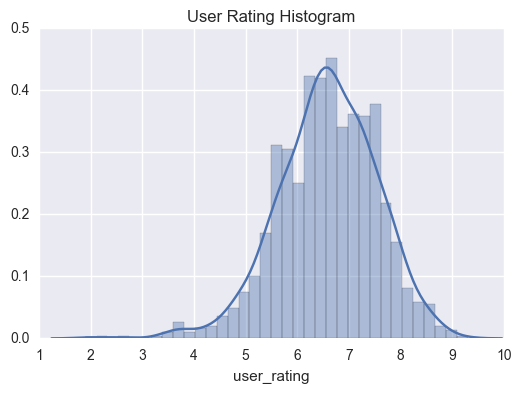

In [284]:
# Plot of user ratings
sns.distplot(df_movie_adjusted.user_rating)
plt.title('User Rating Histogram')

In [285]:
df_movie_adjusted.sort_values('ratingnum', ascending=True)

,user_rating,runtime,ratingnum,mpaa_rating,meta_score,Harrison Ford,Samuel L. Jackson,Morgan Freeman,Tom Hanks,Robert Downey Jr.,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,budget_adj
1277,6.4,111.0,9.264639,Not Rated,48.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.430867e+07
1453,5.8,100.0,9.267760,PG,51.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.320800e+07
1118,5.7,116.0,9.283312,PG-13,36.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.759030e+06
1445,4.6,94.0,9.320808,R,15.0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.688444e+06
1359,4.2,87.0,9.359364,PG,30.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.503334e+07
1354,5.3,88.0,9.384378,PG-13,35.0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.678081e+07
1365,5.6,113.0,9.416460,R,31.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.280384e+07
923,6.4,101.0,9.420358,R,43.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.408186e+05
1185,5.8,95.0,9.442007,R,42.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.027634e+06
1172,6.5,150.0,9.458840,Not Rated,61.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.493782e+07


Lets look at the correlation between the variables and see if we need to drop any highly correlated variables

In [286]:
df_movie_adjusted.corr()

,user_rating,runtime,ratingnum,meta_score,Harrison Ford,Samuel L. Jackson,Morgan Freeman,Tom Hanks,Robert Downey Jr.,Eddie Murphy,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,budget_adj
user_rating,1.000000,0.424058,0.595707,0.729983,0.032833,0.005094,0.064170,0.091591,0.058022,-0.001900,...,-0.012403,-0.111005,-0.074592,-0.066789,-0.072425,-0.023572,-0.005153,0.022532,-0.032579,0.046897
runtime,0.424058,1.000000,0.400491,0.305109,0.062241,0.053811,0.045011,0.100745,0.060647,-0.049559,...,-0.029598,-0.072164,-0.043368,-0.068216,-0.067897,-0.013308,0.025405,0.050190,0.026501,0.296378
ratingnum,0.595707,0.400491,1.000000,0.446337,0.018737,0.029347,0.055856,0.102792,0.109700,0.006792,...,-0.017861,-0.059771,-0.083151,-0.047719,-0.102771,-0.003430,0.085270,0.076517,0.009918,0.386495
meta_score,0.729983,0.305109,0.446337,1.000000,0.036842,0.013944,0.016760,0.074802,0.029181,0.025982,...,-0.005722,-0.097799,-0.068759,-0.037073,-0.018239,-0.003322,-0.030252,0.022656,-0.021992,0.019831
Harrison Ford,0.032833,0.062241,0.018737,0.036842,1.000000,-0.011810,-0.011473,-0.011127,-0.009210,-0.009210,...,-0.026448,-0.003429,-0.030325,-0.002616,-0.030913,-0.029429,0.066319,-0.012769,-0.002767,0.043055
Samuel L. Jackson,0.005094,0.053811,0.029347,0.013944,-0.011810,1.000000,-0.012177,-0.011810,-0.009775,-0.009775,...,-0.001705,0.041818,-0.032187,-0.030426,-0.032811,-0.031235,0.002743,-0.013553,-0.002937,-0.005205
Morgan Freeman,0.064170,0.045011,0.055856,0.016760,-0.011473,-0.012177,1.000000,-0.011473,-0.009496,-0.009496,...,0.026973,-0.005094,-0.031269,-0.029559,-0.008169,-0.030345,0.033591,-0.013167,-0.002853,0.002419
Tom Hanks,0.091591,0.100745,0.102792,0.074802,-0.011127,-0.011810,-0.011473,1.000000,-0.009210,-0.009210,...,-0.026448,-0.029125,-0.005498,-0.002616,-0.006485,-0.003959,-0.024252,-0.012769,-0.002767,0.066266
Robert Downey Jr.,0.058022,0.060647,0.109700,0.029181,-0.009210,-0.009775,-0.009496,-0.009210,1.000000,-0.007623,...,0.045402,0.037768,0.004790,0.039000,0.003823,0.006306,0.016274,-0.010569,-0.002291,0.087071
Eddie Murphy,-0.001900,-0.049559,0.006792,0.025982,-0.009210,-0.009775,-0.009496,-0.009210,-0.007623,1.000000,...,0.011756,-0.024108,-0.025101,0.007636,0.003823,0.006306,-0.020074,-0.010569,-0.002291,0.050386


At first glance, I don't notice a high correlation between variables. When 2 predictor variables are highly correlated this is called multicollinearity and it is something we want to watch out for as it can destabilize our model. In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.
The other takeaway from this table is that some of our predictors are highly correlated with our target variable Y. This is a good thing, it means that these are the variables that we most likely want to include as part of our model as they explain a large amount of the variance in the target variable (correlation=R, variance_explained=R2).

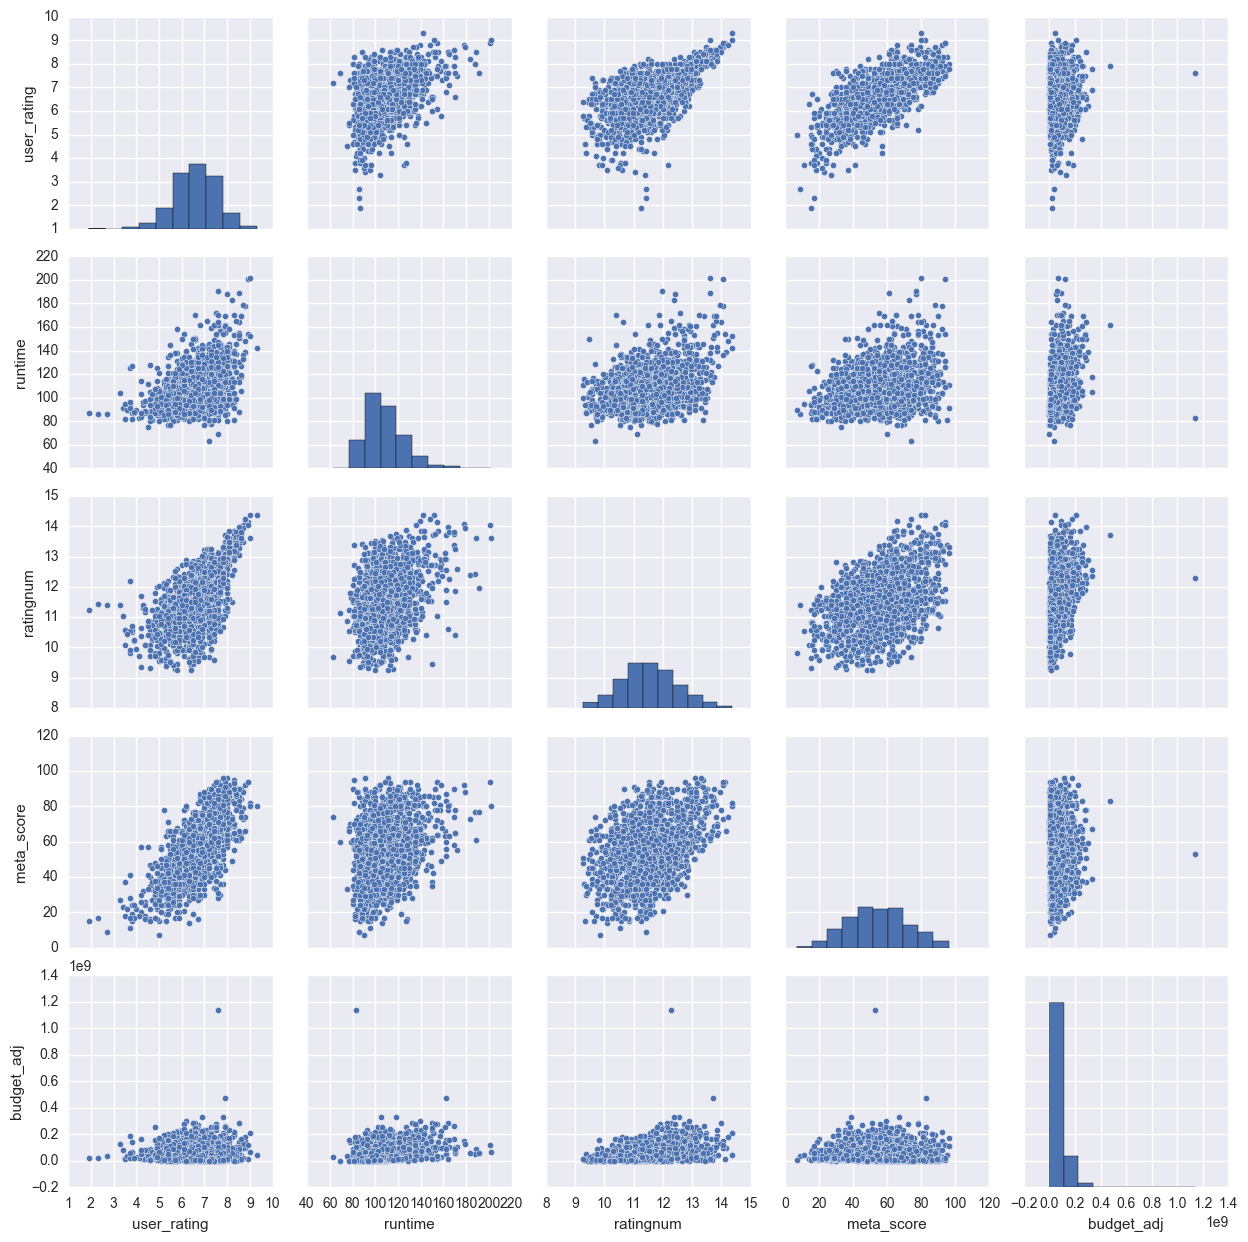

In [287]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df_movie_adjusted[['user_rating', 'runtime','ratingnum', 'meta_score', 'budget_adj']])

In [288]:
# Make MPAA rating into categorical variable using patsy
XR=patsy.dmatrix('mpaa_rating',data=df_movie_adjusted,return_type='dataframe')

In [289]:
df_movie_final=df_movie_adjusted.join(XR)

In [294]:
df_movie_final.columns

Index([u'user_rating', u'runtime', u'ratingnum', u'mpaa_rating', u'meta_score',
       u'Harrison Ford', u'Samuel L. Jackson', u'Morgan Freeman', u'Tom Hanks',
       u'Robert Downey Jr.',
       ...
       u'2013', u'2014', u'2015', u'budget_adj', u'Intercept',
       u'mpaa_rating[T.NC-17]', u'mpaa_rating[T.Not Rated]',
       u'mpaa_rating[T.PG]', u'mpaa_rating[T.PG-13]', u'mpaa_rating[T.R]'],
      dtype='object', length=106)

### Modelling

In [325]:
# run this script to prevent encoding errors
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

### Ordinary Least Squares (OLS) Regression
I will first start with Oridinary Least Squares regression (OLS) usinf ststmodel to get an idea of how the model performs.  

In [295]:
# Create feature matrix (X) and target vector (y)
y = df_movie_final[['user_rating']]
X = df_movie_final.drop(['mpaa_rating','user_rating'],1)
model = sm.OLS(y, X)
# Fit your model to training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            user_rating   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     35.51
Date:                Sun, 16 Apr 2017   Prob (F-statistic):          1.12e-310
Time:                        05:27:16   Log-Likelihood:                -1052.4
No. Observations:                1454   AIC:                             2309.
Df Residuals:                    1352   BIC:                             2848.
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
runtime                      0.0069      0.001      6.584      0.000         0.005     0.009
ratingnum                    0.4041      0.021     19.399      0.000         0.363     0.445
meta_score                   0.0228      0.001     21.946      0.000         0.021     0.025
Harrison Ford               -0.0335      0.145     -0.230      0.818        -0.318     0.251
Samuel L. Jackson           -0.1989      0.127     -1.571      0.116        -0.447     0.049
Morgan Freeman               0.1518      0.132      1.147      0.252        -0.108     0.411
Tom Hanks                   -0.0142      0.140     -0.101      0.919        -0.289     0.261
Robert Downey Jr.            0.2121      0.162      1.309      0.191        -0.106     0.530
Eddie Murphy                -0.0113      0.170     -0.066      0.947        -0.344     0.322
Tom Cruise                  -0.1249      0.165     -0.755      0.450        -0.449     0.199
Johnny Depp                  0.2109      0.161      1.312      0.190        -0.105     0.526
Michael Caine                0.5068      0.188      2.689      0.007         0.137     0.877
Gary Oldman                 -0.0975      0.179     -0.543      0.587        -0.449     0.254
Robin Williams              -0.1209      0.191     -0.633      0.527        -0.496     0.254
Bruce Willis                 0.0258      0.111      0.233      0.816        -0.191     0.243
Robert De Niro              -0.1449      0.120     -1.203      0.229        -0.381     0.091
Matt Damon                   0.1224      0.113      1.082      0.279        -0.100     0.344
Liam Neeson                  0.0924      0.161      0.574      0.566        -0.223     0.408
Scarlett Johansson          -0.1792      0.182     -0.987      0.324        -0.535     0.177
Cameron Diaz                -0.3430      0.140     -2.455      0.014        -0.617    -0.069
Helena Bonham Carter        -0.3197      0.260     -1.231      0.219        -0.829     0.190
Will Smith                  -0.1155      0.170     -0.679      0.497        -0.449     0.218
Julia Roberts               -0.0373      0.162     -0.231      0.818        -0.355     0.280
Steven Spielberg            -0.1080      0.164     -0.658      0.511        -0.430     0.214
James Cameron                0.0425      0.275      0.154      0.877        -0.497     0.582
Woody Allen                  0.5381      0.308      1.748      0.081        -0.066     1.142
Martin Scorsese             -0.2097      0.257     -0.818      0.414        -0.713     0.294
Clint Eastwood              -0.1433      0.206     -0.695      0.487        -0.548     0.261
David Fincher               -0.0882      0.222     -0.397      0.691        -0.524     0.348
Ridley Scott                 0.0760      0.209      0.364      0.716        -0.333     0.485
Robert Zemecki

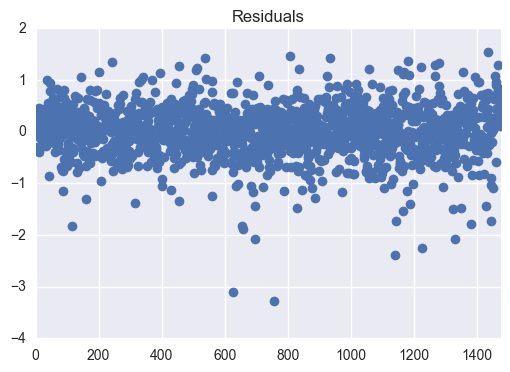

In [296]:
# Use statsmodels to plot the residuals
fit.resid.plot(style='o')
plt.title('Residuals')

From this we get a handful of useful statistics describing our regression. Our R-squared value is 0.726, which means 72.6% of the variation in your response variable can be explained with a linear relationship with the predictor. Some p-values are also higher than 0.05, which I will filter out and run another regression for comaprison.

In [322]:
# Filtering features using p-value < 0.05: 
est=LinearRegression()
from sklearn import feature_selection as f_select
sig_columns=[]
pvals=[]
for feature in X.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(X[[feature]],y)
    if pval[1][0]<.05: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])    
X_filter=X[sig_columns]

In [323]:
X_filter.columns

Index([u'runtime', u'ratingnum', u'meta_score', u'Morgan Freeman',
       u'Tom Hanks', u'Robert Downey Jr.', u'Tom Cruise', u'Michael Caine',
       u'Matt Damon', u'Steven Spielberg', u'James Cameron',
       u'Martin Scorsese', u'Clint Eastwood', u'David Fincher',
       u'Ridley Scott', u'Robert Zemeckis', u' Horror', u' Drama', u' Action',
       u' Family', u' Fantasy', u' Crime', u' Animation', u' Comedy', u' War',
       u' Romance', u'1974', u'1975', u'1976', u'1978', u'1979', u'1982',
       u'1985', u'1989', u'1992', u'1993', u'1994', u'1995', u'1996', u'1998',
       u'1999', u'2008', u'2009', u'2010', u'2011', u'mpaa_rating[T.PG]',
       u'mpaa_rating[T.PG-13]', u'mpaa_rating[T.R]'],
      dtype='object')

### Regression with sklearn
Statsmodels has decent functionality for linear models, but scikit-learn has a massive amount of modeling options for all sorts of algorithms as well as data preparation and is growing every day, so I will generally be working with that from here on. Before I jump into some of the additional features of sklearn, I will try to repeat the same process as above example using sklearn's built in LinearRegression.

In [308]:
# Create an empty model
lr = LinearRegression()
# Fit the model to the full dataset
fit = lr.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.72622223409984188

The R2 value is the same again. Let's look at the Q-Q plot and the regression output.

In [334]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(10,5))
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)
   
    plt.subplot(1, 2, 1)
    plt.scatter(y, pred, color='blue')
    plt.plot([0,12], [0,12])
    plt.title("Regression fit")
    plt.xlabel("y actual")
    plt.ylabel("y predicted")
   
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res.ravel(), dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

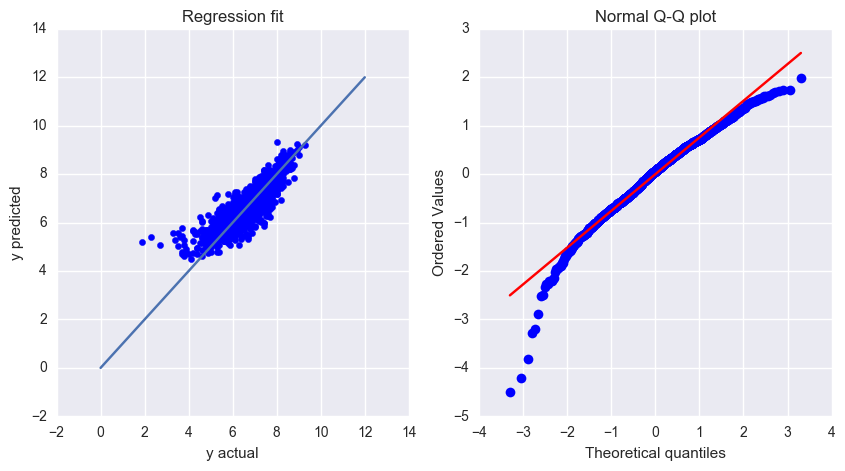

In [335]:
diagnostic_plot(X,y)

### Cross validation and Lasso Regression
I am going to use cross validation and divide the data into a test and training set. I will train my Lasso regression model on the training set and use the test set to predict the results and calculate score. I chose Lasso as there are a large number of categorical variables which will be set to zero, which is a property of Lasso.


In [336]:
#Normalize data
from sklearn.preprocessing import normalize
col_list_x=X.columns
col_list_y=y.columns
X_nm=normalize(X,axis=0,norm='max')
y_nm=normalize(y,axis=0,norm='max')

In [337]:
X_cv=pd.DataFrame(X_nm, columns=col_list_x)
y_cv=pd.DataFrame(y_nm, columns=col_list_y)

In [338]:
#Running Lasso Regression

In [339]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
# Lasso using cross validation

# A bit more involved approach: illustrated here with Lasso
kf = KFold(n=len(X_nm), n_folds=10, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-2,1e-1,0.15,0.2]

for train, test in kf:
    X_train=X_cv.iloc[train]
    y_train=y_cv.iloc[train]
    X_test=X_cv.iloc[test]
    y_test=y_cv.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(X_train,y_train)
        p = est.predict(X_test)
        y_test2=np.array(y_test)
        mse=np.mean((y_test2-p)**2)
        mse_score.append(mse)
    all_scores.append(mse_score) 


In [340]:
all_scores[2]

[0.016578522558836423,
 0.014026752271957543,
 0.009384455416884669,
 0.0090523895399297581,
 0.0090523895399297581,
 0.0090523895399297581]

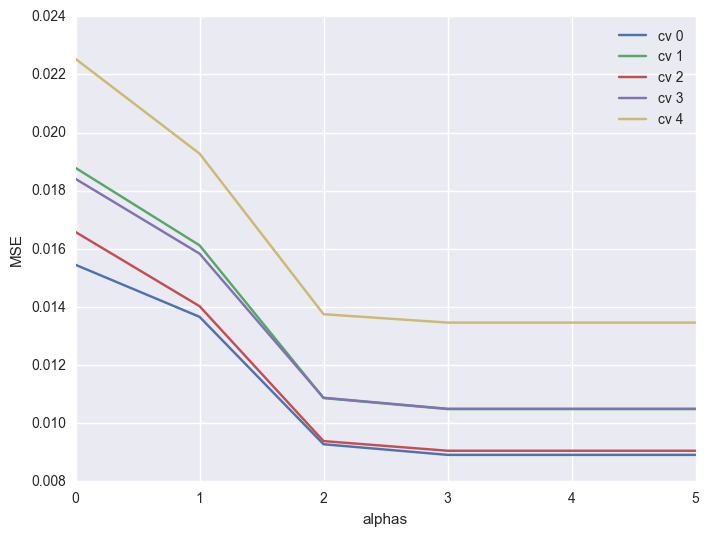

In [341]:
# Which alpha is the best for our model ? Looks like alpha= 1e-3
plt.figure(figsize=(8,6))
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [342]:
X_train.head()

,runtime,ratingnum,meta_score,Harrison Ford,Samuel L. Jackson,Morgan Freeman,Tom Hanks,Robert Downey Jr.,Eddie Murphy,Tom Cruise,...,2013,2014,2015,budget_adj,Intercept,mpaa_rating[T.NC-17],mpaa_rating[T.Not Rated],mpaa_rating[T.PG],mpaa_rating[T.PG-13],mpaa_rating[T.R]
0,0.762376,0.982997,0.979167,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.011413,1.0,0.0,0.0,0.0,0.0,1.0
1,0.702970,0.884259,0.552083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.178620,1.0,0.0,0.0,0.0,1.0,0.0
2,0.702970,1.000000,0.833333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.035666,1.0,0.0,0.0,0.0,0.0,1.0
3,0.574257,0.942253,0.895833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.037334,1.0,0.0,0.0,1.0,0.0,0.0
4,0.584158,0.955632,0.875000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.031047,1.0,0.0,0.0,0.0,0.0,1.0


In [343]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.3)
est=Lasso(alpha=0.001)
est.fit(X_train,y_train)

zipped=zip(X_cv.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
print features
p = est.predict(X_test)
y_test2=np.array(y_test)
mse=np.sum((y_test2-p)**2)
print mse
est.score(X_test, y_test)

0.61916075061490794

In [352]:
ols_col_list = []
for pair in features:
    if pair[1] == 0 and pair[0]!="Intercept":
        ols_col_list.append(pair[0])
#ols_col_list

In [359]:
features

[('ratingnum', 0.32964349206350008),
 ('meta_score', 0.2847983053858868),
 (' Drama', 0.025676152019377479),
 ('runtime', 0.024077486115522413),
 ('mpaa_rating[T.R]', 0.014577280248595652),
 ('Harrison Ford', -0.0),
 ('Samuel L. Jackson', -0.0),
 ('Morgan Freeman', 0.0),
 ('Tom Hanks', 0.0),
 ('Robert Downey Jr.', 0.0),
 ('Eddie Murphy', -0.0),
 ('Tom Cruise', 0.0),
 ('Johnny Depp', 0.0),
 ('Michael Caine', 0.0),
 ('Gary Oldman', -0.0),
 ('Robin Williams', 0.0),
 ('Bruce Willis', 0.0),
 ('Robert De Niro', 0.0),
 ('Matt Damon', 0.0),
 ('Liam Neeson', -0.0),
 ('Scarlett Johansson', -0.0),
 ('Cameron Diaz', -0.0),
 ('Helena Bonham Carter', -0.0),
 ('Will Smith', 0.0),
 ('Julia Roberts', -0.0),
 ('Steven Spielberg', -0.0),
 ('James Cameron', 0.0),
 ('Woody Allen', 0.0),
 ('Martin Scorsese', 0.0),
 ('Clint Eastwood', 0.0),
 ('David Fincher', 0.0),
 ('Ridley Scott', 0.0),
 ('Robert Zemeckis', -0.0),
 ('Ang Lee', -0.0),
 ('Alejandro G. I\xc3\xb1\xc3\xa1rritu', 0.0),
 (' Adventure', -0.0),
 ('

In [353]:
# Let's see what result the feature list from Lasso gives up
# if we use OLS
y_ols = y
X_ols = X.drop(ols_col_list,1)

In [354]:
model = sm.OLS(y_ols, X_ols)
# Fit your model to training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            user_rating   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     238.0
Date:                Sun, 16 Apr 2017   Prob (F-statistic):               0.00
Time:                        09:57:10   Log-Likelihood:                -1160.4
No. Observations:                1454   AIC:                             2349.
Df Residuals:                    1440   BIC:                             2423.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
runtime                  0.0048      0.001      4.964      0.000         0.003     0.007
ratingnum                0.3730      0.019     19.519      0.000         0.336     0.411
meta_score               0.0253      0.001     24.854      0.000         0.023     0.027
 Horror                 -0.1789      0.048     -3.698      0.000        -0.274    -0.084
 Thriller               -0.0219      0.035     -0.620      0.535        -0.091     0.047
 Drama                   0.2402      0.034      6.997      0.000         0.173     0.308
 Action                 -0.1594      0.036     -4.458      0.000        -0.229    -0.089
 Fantasy                -0.1400      0.043     -3.229      0.001        -0.225    -0.055
 Comedy                 -0.0805      0.038     -2.126      0.034        -0.155    -0.006
2008                    -0.1261      0.056     -2.257      0.024        -0.236    -0.016
2011                    -0.0771      0.053     -1.451      0.147        -0.181     0.027
Intercept                0.4687      0.197      2.377      0.018         0.082     0.855
mpaa_rating[T.PG-13]    -0.1706      0.045     -3.795      0.000        -0.259    -0.082
mpaa_rating[T.R]         0.0477      0.045      1.048      0.295        -0.042     0.137
==============================================================================
Omnibus:                      162.701   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.786
Skew:                          -0.588   Prob(JB):                    1.44e-100
Kurtosis:                       5.491   Cond. No.                     1.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-sqaured value is nearly the same as the Lasso score.

In [361]:
top_features = {'ratingnum' : 0.32964349206350008, 'meta_score' : 0.2847983053858868, 
                'Drama' : 0.025676152019377479, 
                'runtime' : 0.024077486115522413,
                'mpaa_rating[T.R]' : 0.014577280248595652, 
                'Thriller' : -0.0010904726066996637, 
                'Fantasy': -0.002377856398317231,
                '2008' : -0.0030765790818534015,
                'mpaa_rating[T.PG-13]' : -0.0037371614110871467,
                '2011' : -0.0046887050799828238,
                'Action' : -0.0061476488049889552,
                'Comedy' : -0.0082150006663209811,
                'Horror' : -0.017491944335434568}

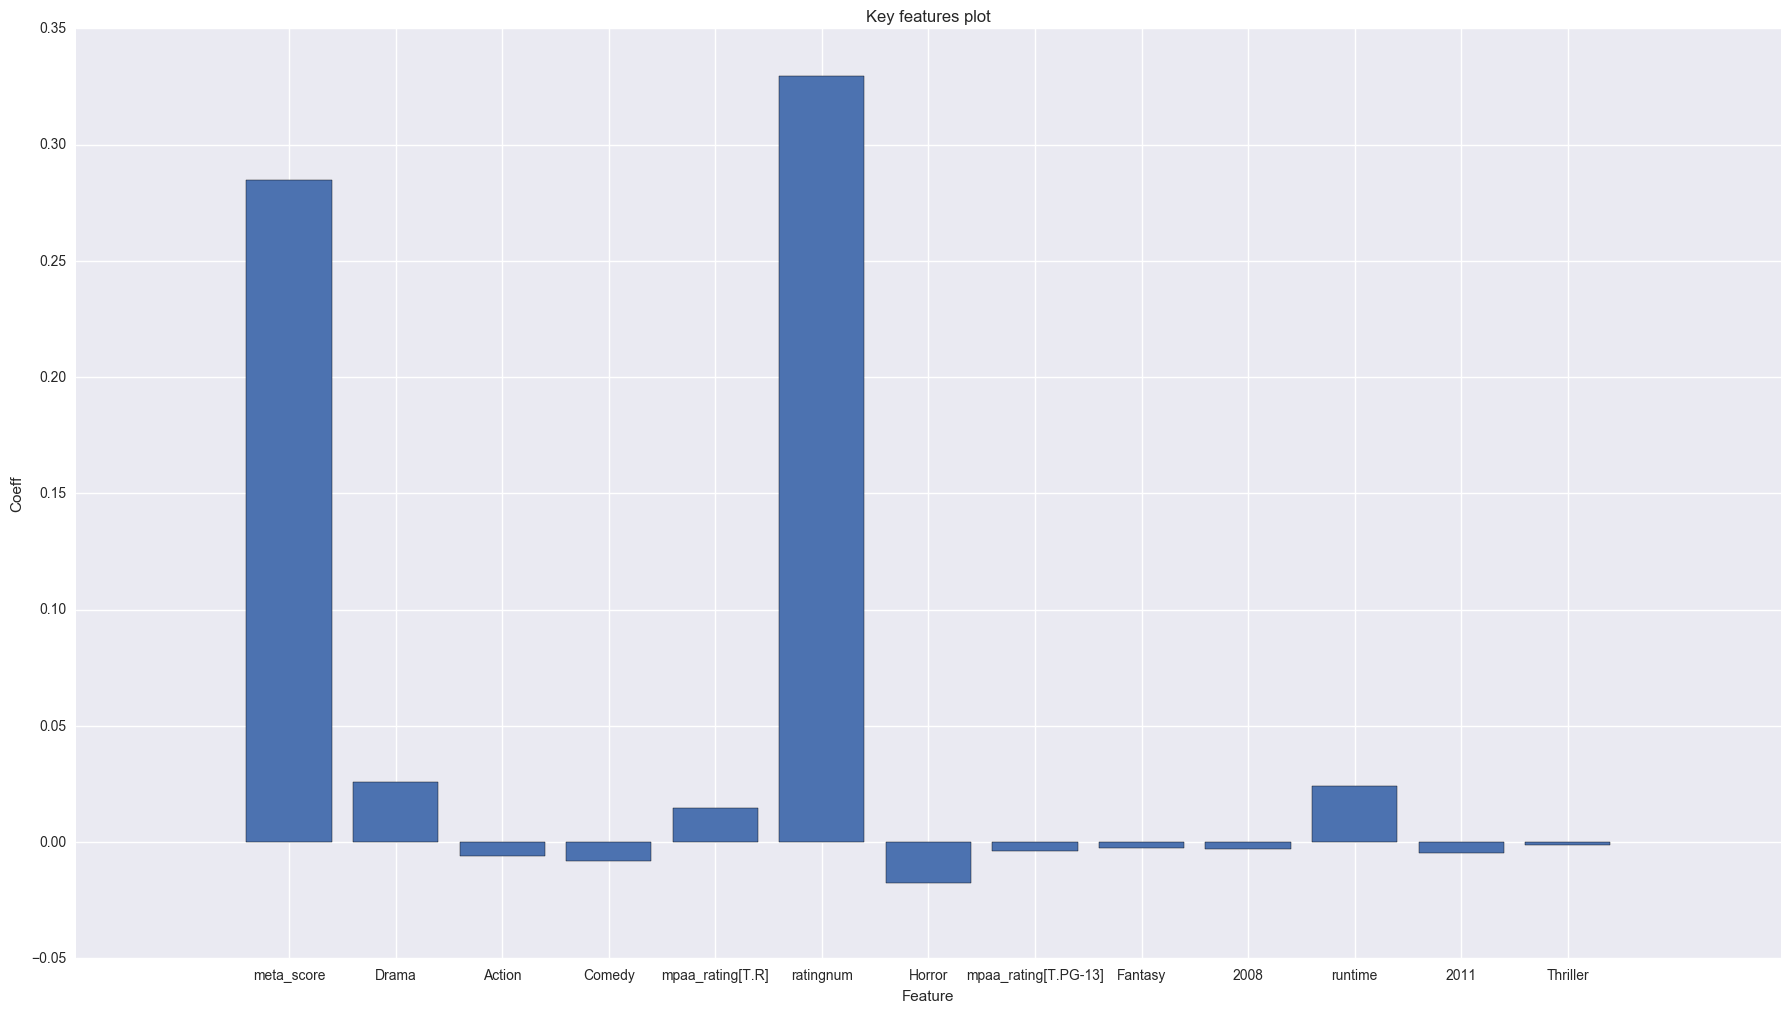

In [369]:
plt.figure(figsize=(22,12))
plt.bar(range(len(top_features)), top_features.values(), align='center')
plt.xticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature')
plt.ylabel('Coeff')
plt.title("Key features plot")
plt.show()